# UPS Stochastic MV Framework

### Import Libraries

In [4]:
from AssetAllocation.datamanager import datamanager as dm
from AssetAllocation.analytics import summary
from AssetAllocation.analytics.stoch_mv import stochMV
from AssetAllocation.reporting import reports as rp, plots, formatter as fmt
import numpy as np
import kaleido
from ipywidgets import interact, interact_manual

PLAN = 'IBT'

### Model liability of Plan

In [5]:
liab_model = summary.get_liab_model(PLAN)

### Compute plan inputs

In [6]:
pp_inputs = summary.get_pp_inputs(liab_model,PLAN)

### Initialize plan object and display relevant variables

In [7]:
plan = summary.get_plan_params(pp_inputs)

#Display plan inputs
pp_dict = plan.get_pp_dict()
@interact
def display_pp_inputs(variable=pp_dict.keys()):
    if variable == 'Corr' or variable == 'Cov':
        return plots.draw_heatmap(pp_dict[variable], half=False)
    else:
        return fmt.get_plan_styler(pp_dict[variable])

interactive(children=(Dropdown(description='variable', options=('Policy Weights', 'Asset/Liability Returns/Vol…

### Initialize stoch MV object, generate random returns and resampled correaltions

In [8]:
#initialize the stochastic mean variance and generate the random returns
num_of_plans = 120
s = stochMV(plan, num_of_plans)
s.generate_plans()
s.generate_resamp_corr_dict()

### View Simulated Return Data

In [9]:
fmt.get_plan_styler(s.returns_df)

,Liability,15+ STRIPS,Long Corporate,Ultra 30Y Futures,Equity,Liquid Alternatives,Private Equity,Credit,Real Estate,Cash,Hedges
Sample,,,,,,,,,,,
0,0.13%,-2.38%,-0.07%,-3.78%,9.21%,5.06%,4.20%,4.09%,5.66%,2.02%,4.06%
1,11.82%,11.16%,8.85%,7.49%,12.05%,6.65%,11.30%,7.06%,6.47%,2.02%,0.53%
2,7.03%,0.23%,5.75%,-1.62%,15.84%,6.00%,8.64%,7.02%,5.46%,2.02%,1.19%
3,0.45%,-5.37%,-0.40%,-5.20%,7.54%,3.31%,8.37%,4.68%,5.26%,2.02%,3.12%
4,11.65%,16.86%,8.08%,10.83%,0.45%,4.27%,10.85%,6.90%,3.95%,2.02%,3.57%
5,3.71%,3.01%,3.49%,1.79%,8.13%,3.37%,7.30%,5.73%,5.09%,2.02%,1.00%
6,-1.07%,-4.66%,-2.01%,-4.15%,4.21%,2.83%,1.33%,2.51%,0.75%,2.02%,3.58%
7,4.16%,-1.35%,2.62%,-2.77%,11.19%,4.30%,10.49%,7.95%,6.32%,2.02%,2.95%
8,1.63%,2.40%,0.24%,1.13%,5.14%,-0.07%,10.87%,3.96%,3.06%,2.02%,3.94%


### View Resampled Correlations

In [ ]:
@interact
def display_resampled_corr(asset_liab=s.resamp_corr_dict.keys()):
    resamp_corr_fig = plots.get_resamp_corr_fig(s.resamp_corr_dict[asset_liab], asset_liab)
    resamp_corr_fig.show()

interactive(children=(Dropdown(description='asset_liab', options=('Liability', '15+ STRIPS', 'Long Corporate',…

### View Simulated Returns Plots

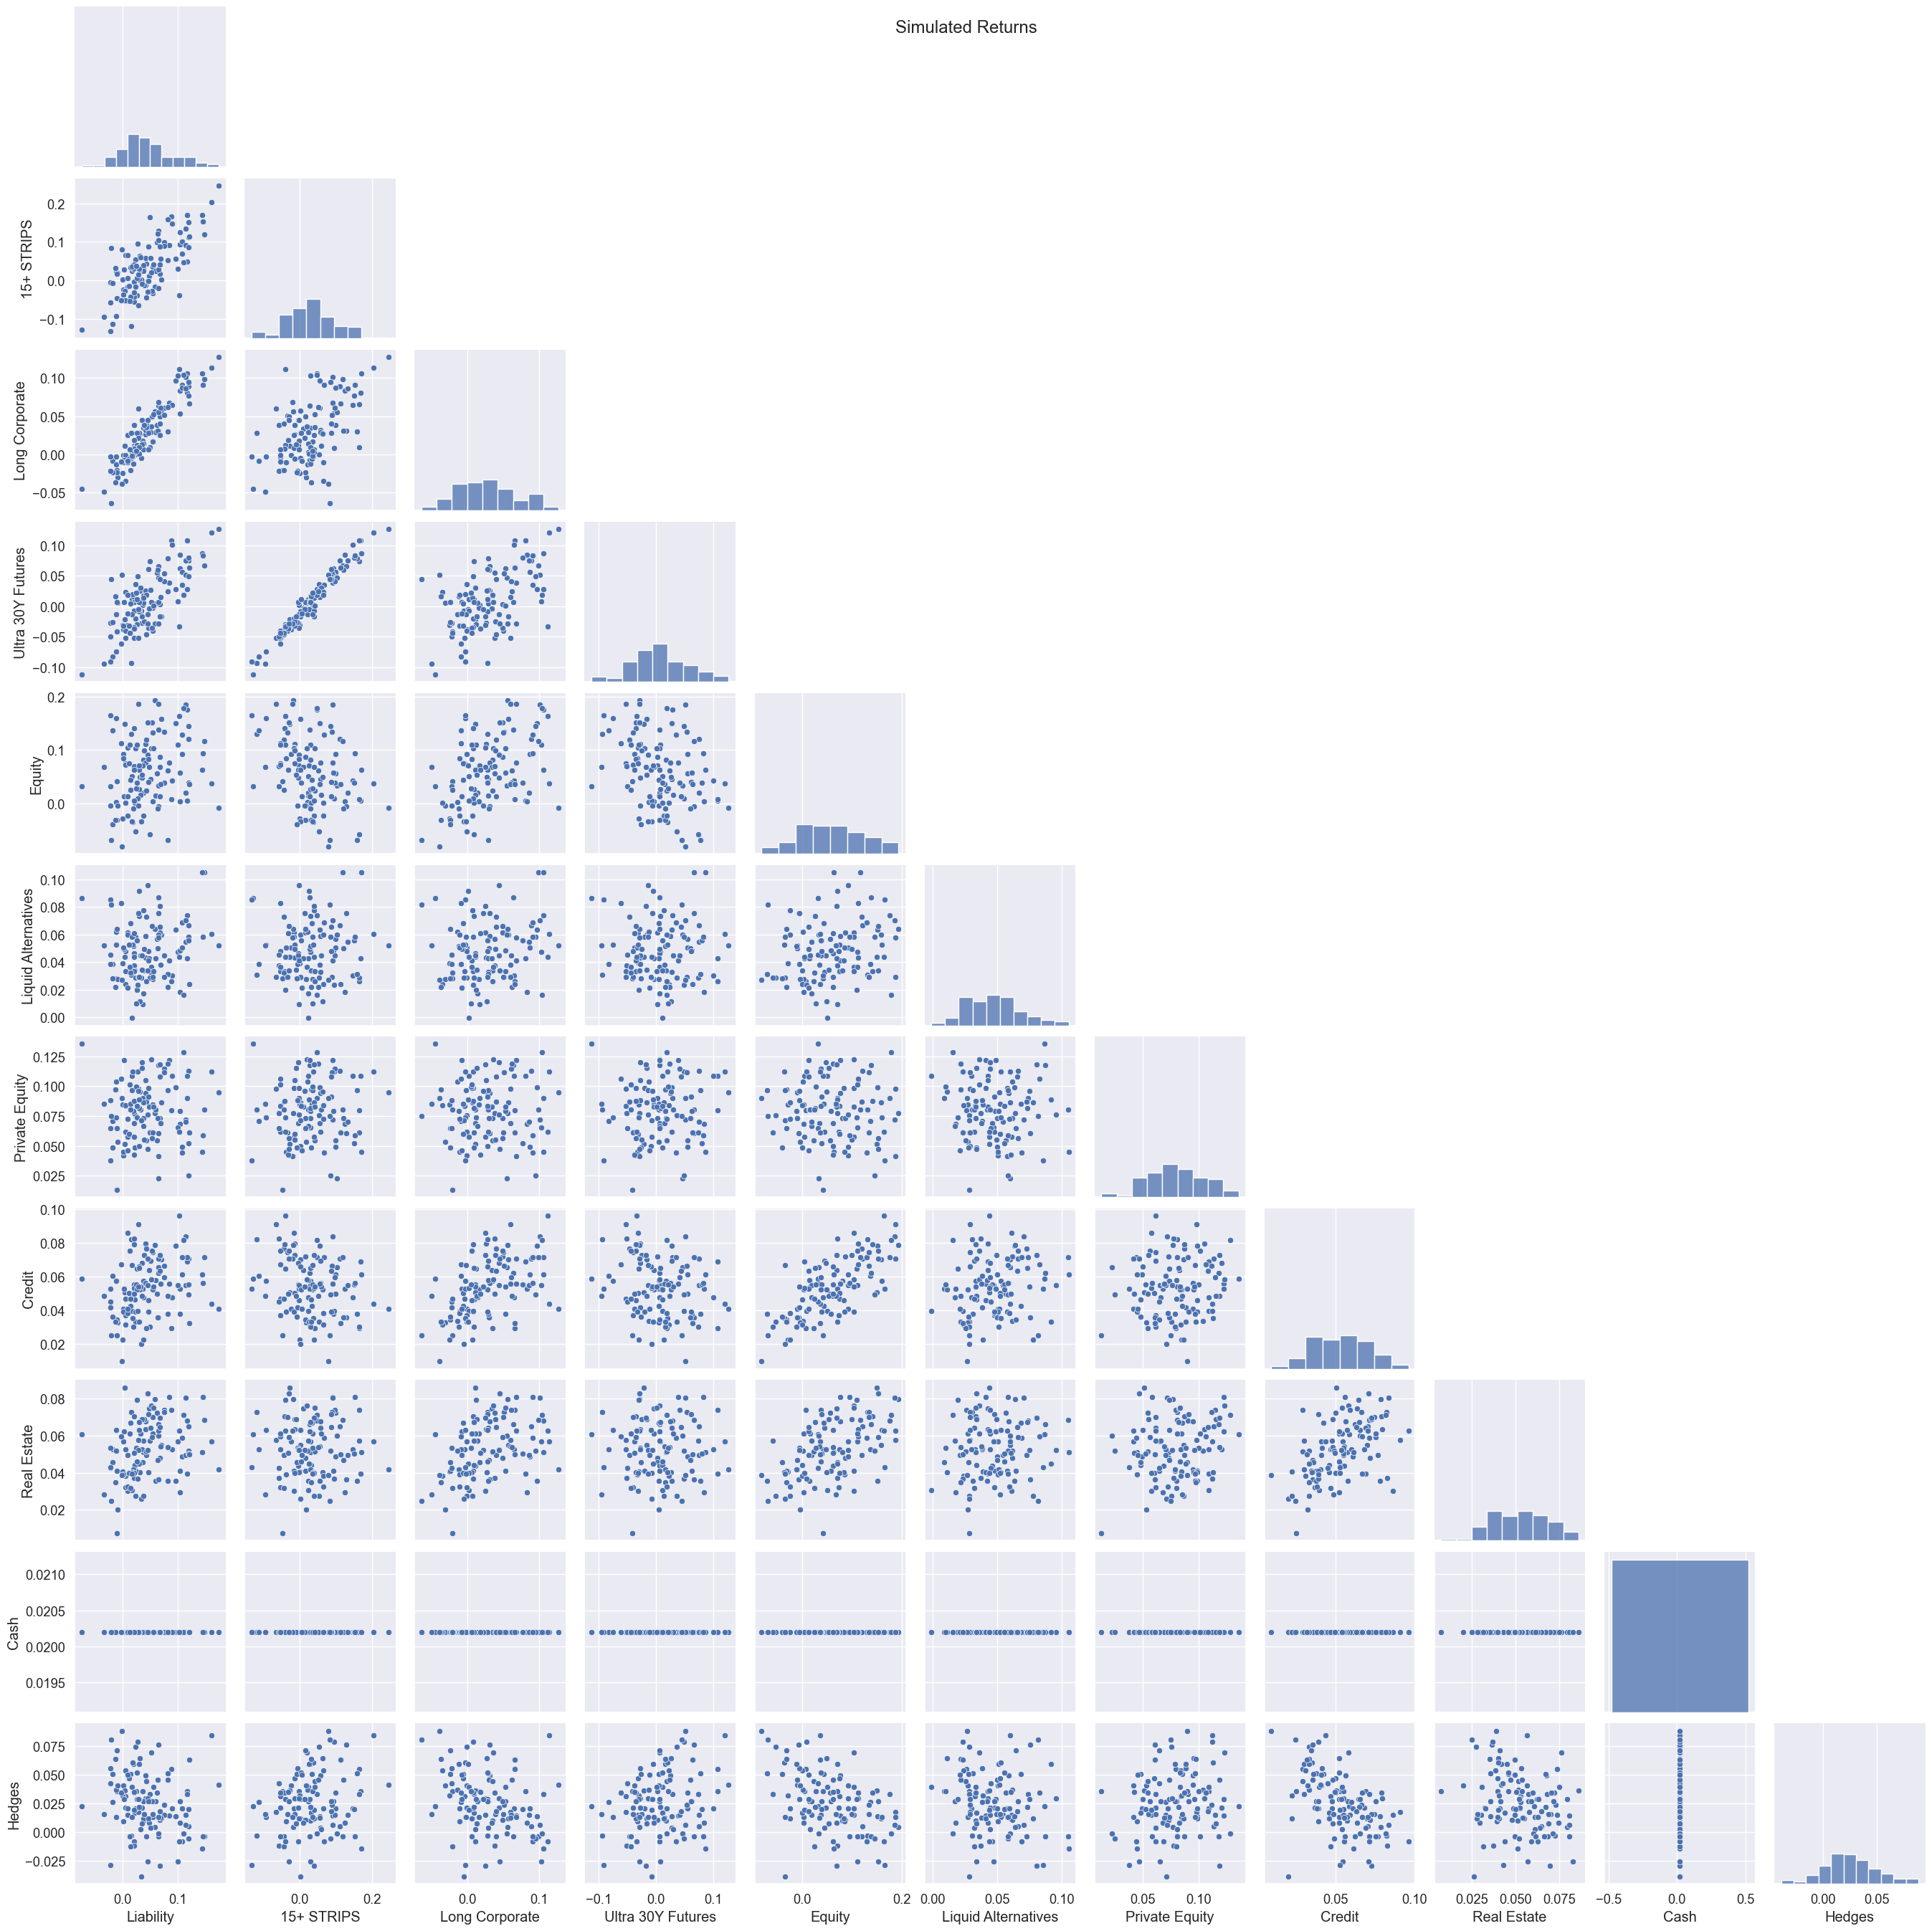

In [11]:
#visualize the simulated returns
plots.get_sim_return_fig(s)

### Define bounds
* Bounds data is stored in **'data/plan_inputs/bounds.xlsx'** by plan

In [12]:
bnds = dm.get_bounds(plan.funded_status,plan=PLAN)

@interact
def view_update_bnds(asset = plan.bnds_dict['asset_list'],reset=False,
                     lower=plan.bnds_dict['lower_bnd'],upper=plan.bnds_dict['upper_bnd'],reset_asset=False):
    if lower:
        fmt.update_lower_bnds(bnds, asset,lower,plan)
    if upper:
        fmt.update_upper_bnds(bnds, asset,upper,plan)
    if reset:
        fmt.reset_bnds(bnds,PLAN)
    if reset_asset:
        fmt.reset_asset_bnds(bnds,asset,PLAN)
    return fmt.get_plan_styler(bnds)

interactive(children=(Dropdown(description='asset', options=('15+ STRIPS', 'Long Corporate', 'Ultra 30Y Future…

### Define contraints to optimize for min and max return
* Current constraints:
    * 45% <= sum(Fixed Income Assets weights) <= 55%
    * sum(All plan assets weights (excluding Futures & Hedges)) = Funded Status Diff
    * Hedges weights <= sum(50% of Equity & Private Equity weights)
    * 15+ STRIPS weight >= sum(50% of Futures and 25% of Hedges weights)

In [13]:
cons = (
        # 45% <= sum of Fixed Income Assets <= 55%
        {'type': 'ineq', 'fun': lambda x: np.sum(x[1:3]) - 0.45*s.init_plan.funded_status},
        {'type': 'ineq', 'fun': lambda x: .55*s.init_plan.funded_status - np.sum(x[1:3])},
        #sum of all plan assets (excluding Futures and Hedges) = Funded Status Difference    
        {'type': 'eq', 'fun': lambda x: np.sum(x[0:len(s.init_plan)-1]) - x[3] + (1-s.init_plan.funded_status)},
        # 50% of Equity and PE >= Hedges
        {'type': 'ineq', 'fun': lambda x: (x[4]+x[6])*.5 - x[len(s.init_plan)-1]},
        # 15+ STRIPS >= sum(50% of Futures and 25% of Hedges weights)
        {'type': 'ineq', 'fun': lambda x: x[1] - (x[3]/2+x[len(s.init_plan)-1]/4)}
        )

### Compute MV Efficient Frontier for each of the simulated plans

In [14]:
# computation of the efficient frontier for each of the simulated plan
s.generate_efficient_frontiers(bnds, cons,num_ports=100)

### Display stoch MV Efficient Frontier portfolios

In [15]:
# output the dataframe which has the average allocation
fmt.get_port_styler(s.opt_ports_df)

,Asset Return,Excess Return,Surplus Volatility,Sharpe,15+ STRIPS,Long Corporate,Ultra 30Y Futures,Equity,Liquid Alternatives,Private Equity,Credit,Real Estate,Cash,Hedges
Portfolio,,,,,,,,,,,,,,
0,3.65%,-0.53%,3.39%,-0.1561,17.64%,32.93%,35.19%,19.16%,4.64%,2.95%,9.17%,4.53%,0.92%,0.17%
1,3.66%,-0.52%,3.39%,-0.1542,17.65%,32.92%,35.19%,19.21%,4.52%,3.17%,9.16%,4.39%,0.92%,0.19%
2,3.67%,-0.52%,3.40%,-0.1520,17.65%,32.91%,35.20%,19.27%,4.39%,3.42%,9.16%,4.22%,0.92%,0.22%
3,3.67%,-0.51%,3.40%,-0.1500,17.66%,32.90%,35.19%,19.33%,4.27%,3.64%,9.15%,4.06%,0.92%,0.25%
4,3.68%,-0.50%,3.40%,-0.1477,17.67%,32.89%,35.19%,19.40%,4.16%,3.89%,9.13%,3.87%,0.92%,0.30%
5,3.69%,-0.50%,3.40%,-0.1457,17.68%,32.89%,35.18%,19.44%,4.05%,4.12%,9.10%,3.74%,0.92%,0.34%
6,3.69%,-0.49%,3.40%,-0.1433,17.68%,32.88%,35.16%,19.49%,3.94%,4.36%,9.07%,3.58%,0.92%,0.40%
7,3.70%,-0.48%,3.40%,-0.1409,17.69%,32.87%,35.15%,19.55%,3.82%,4.62%,9.04%,3.42%,0.92%,0.46%
8,3.71%,-0.47%,3.41%,-0.1390,17.70%,32.86%,35.14%,19.59%,3.75%,4.82%,9.00%,3.29%,0.92%,0.53%


### Display MV Asset Allocation

In [16]:
#Asset Allocation Plot
aa_fig = plots.get_aa_fig(s.opt_ports_df)
aa_fig.show()

### Display MV Efficient Frontier

In [17]:
#Plotly version of the Efficient Frontier plot
ef_fig = plots.get_ef_fig(s.opt_ports_df)
ef_fig.show()

In [18]:
rp.get_stochmv_ef_portfolios_report(PLAN+' stochmv_ef_report', s,bnds)

"IBT stochmv_ef_report.xlsx" report generated in "C:\Users\Roxton McNeal\Documents\GitHub\UPS_MV\reports\" folder
